# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math, sys, os

sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from plotter import *


In [2]:
# Import tdmclient Notebook environment:
import tdmclient.notebook
await tdmclient.notebook.start()

### Instantiation of all the constants : 

In [3]:
#Constants
Ts = 0.1
thymio_speed_to_mms = 0.341
distance_wheel = 95

#Thymio goes forward
q_F_x = 0.008
q_F_y =  0.008
q_F_theta = 0.000006
q_F_x_dot = 0.779  
q_F_y_dot =  0.779  
q_F_theta_dot = 0.000591

Q_F = np.array([[q_F_x, 0, 0, 0, 0, 0], 
                [0, q_F_y, 0, 0, 0, 0], 
                [0, 0, q_F_theta, 0, 0, 0],
                [0, 0, 0, q_F_x_dot, 0, 0], 
                [0, 0, 0, 0, q_F_y_dot, 0], 
                [0, 0, 0, 0, 0, q_F_theta_dot]]);

r_F_x_dot = 0.779  
r_F_y_dot = 0.779
r_F_theta_dot = 0.000591

R_F = np.array([[r_F_x_dot, 0, 0],
               [0, r_F_y_dot, 0],
               [0, 0, r_F_theta_dot]]);

A_F = np.array([[1, 0, 0, Ts, 0, 0], 
                [0, 1, 0, 0, Ts, 0], 
                [0, 0, 1, 0, 0, 0],
                [0, 0, 0, 1, 0, 0], 
                [0, 0, 0, 0, 1, 0], 
                [0, 0, 0, 0, 0, 1]]);


#Thymio rotates
q_R_x = 0.01
q_R_y =  0.01
q_R_theta = 0.00001 
q_R_x_dot = 1.31
q_R_y_dot =  1.31
q_R_theta_dot = 0.00122

Q_R = np.array([[q_R_x, 0, 0, 0, 0, 0], 
                [0, q_R_y, 0, 0, 0, 0], 
                [0, 0, q_R_theta, 0, 0, 0],
                [0, 0, 0, q_R_x_dot, 0, 0], 
                [0, 0, 0, 0, q_R_y_dot, 0], 
                [0, 0, 0, 0, 0, q_R_theta_dot]]);

r_R_x_dot = 1.31
r_R_y_dot = 1.31
r_R_theta_dot = 0.00122  

R_R = np.array([[r_R_x_dot, 0, 0],
               [0, r_R_y_dot, 0],
               [0, 0, r_R_theta_dot]]);

A_R = np.array([[1, 0, 0, 0, 0, 0], 
                [0, 1, 0, 0, 0, 0], 
                [0, 0, 1, 0, 0, Ts],
                [0, 0, 0, 1, 0, 0], 
                [0, 0, 0, 0, 1, 0], 
                [0, 0, 0, 0, 0, 1]]);

# commun matrix
H = np.array([[0, 0, 0, 1, 0, 0], 
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]]);



### Code of Kalman function :

In [4]:
def kalman_filter(meas_speed_left, meas_speed_right, x_est_prev, P_est_prev, Q, R, A):
    
    
    ## Prediciton through the a priori estimate
    # estimated mean of the state
    x_est_a_priori = np.dot(A, x_est_prev) 
    
    # Estimated covariance of the state
    P_est_a_priori = np.dot(A, np.dot(P_est_prev, A.T))
    P_est_a_priori = P_est_a_priori + Q
    
    
    #measurements
    speed_trans = (meas_speed_left + meas_speed_right) * thymio_speed_to_mms / 2
    speed_rot =  (meas_speed_right - meas_speed_left) * (thymio_speed_to_mms / distance_wheel)
    
    theta_est = x_est_a_priori[2];
    x_dot = speed_trans * math.cos(theta_est)
    y_dot = speed_trans * math.sin(theta_est)
    theta_dot = speed_rot
    
    y = np.array([[x_dot], [y_dot], [theta_dot]])
   

    # innovation / measurement residual
    i = y - np.dot(H, x_est_a_priori)
    # measurement prediction covariance
    S = np.dot(H, np.dot(P_est_a_priori, H.T)) + R
             
    # Kalman gain (tells how much the predictions should be corrected based on the measurements)
    K = np.dot(P_est_a_priori, np.dot(H.T, np.linalg.inv(S)))
    
    
    # a posteriori estimate
    x_est = x_est_a_priori + np.dot(K,i)
    P_est = P_est_a_priori - np.dot(K,np.dot(H, P_est_a_priori))
    
    return x_est, P_est

### Utilization of Kalman : 

In [5]:
camera_on = False

In [6]:
from threading import Timer

class RepeatedTimer(object):
    def __init__(self, interval, function, *args):
        self._timer     = None
        self.interval   = interval
        self.function   = function
        self.args       = args
        self.is_running = False
        self.start()

    def _run(self):
        self.is_running = False
        self.start()
        self.function(*self.args)

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False

In [7]:
%%run_python

state = 1

@onevent
def move(speed_left, speed_right):
    global motor_left_target, motor_right_target, state
    if state == 1 :
        motor_left_target = speed_left
        motor_right_target = speed_right
    
@onevent 
def button_center():
    global state, motor_left_target, motor_right_target
    state = 0
    motor_left_target = 0
    motor_right_target = 0

In [8]:
def send_command():
    if optimal_command[step][0] == optimal_command[step][1] and optimal_command[step][0] != 0:
        send_event("move", optimal_command[step][0] + 2, optimal_command[step][1] - 2)
    else :
        send_event("move", optimal_command[step][0], optimal_command[step][1])

In [9]:
@tdmclient.notebook.sync_var
def get_speed():
    return motor_left_speed, motor_right_speed

def kalman_call():
    global step, x_est, start
    
    if step < len(optimal_command) :
        #retrieves the equivalent of the command that was applied Ts seconds ago
        speed_left = optimal_command[step][0]
        speed_right = optimal_command[step][1]

        speed_trans = (speed_left + speed_right) * thymio_speed_to_mms / 2
        speed_rot =  (speed_right - speed_left) * (thymio_speed_to_mms / distance_wheel)

        theta = x_est[-1][2];

        x_est[-1][3] = speed_trans * math.cos(theta)
        x_est[-1][4] = speed_trans * math.sin(theta)
        x_est[-1][5] = speed_rot

        #gets the right matrix corresponding to the command :
        #Thymio goes forward
        if speed_left == speed_right :
            Q = Q_F
            R = R_F
            A = A_F

        #Thymio is rotating
        else :
            Q = Q_R
            R = R_R
            A = A_R


        #measures the speed of the robot
        meas_speed_left,  meas_speed_right = get_speed()

        #computes the estimated states
        new_x_est, new_P_est = kalman_filter(meas_speed_left, meas_speed_right, x_est[-1], P_est[-1], Q, R, A)

        x_est.append(new_x_est)
        P_est.append(new_P_est)

        step += 1

        if step < len(optimal_command) :
            send_command()

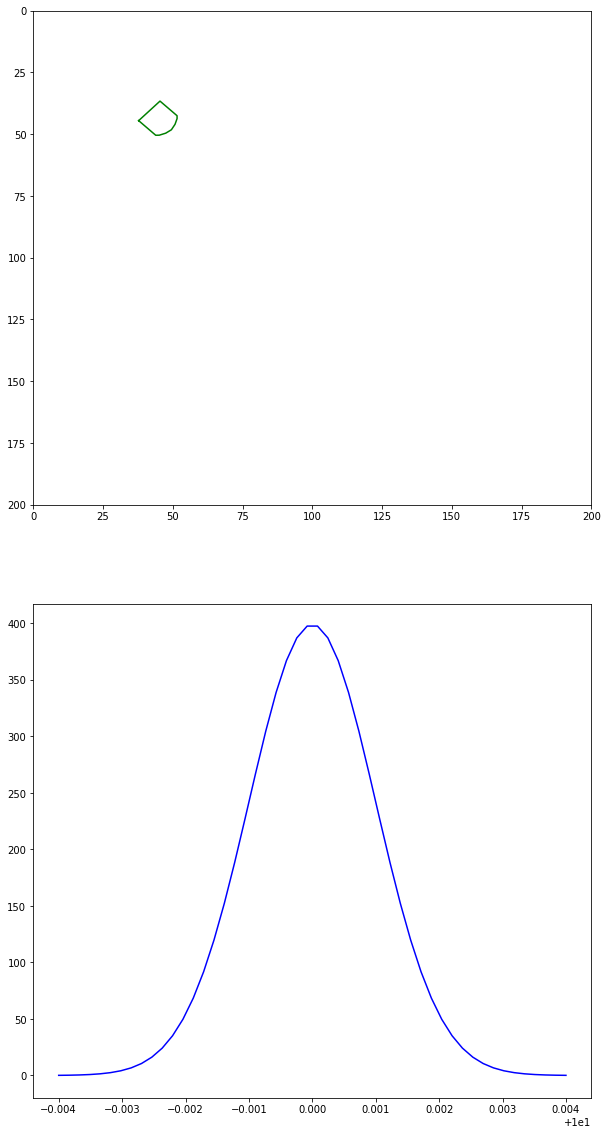

In [10]:
#initial state :
x0 = 10
y0 = 10
theta0 = 0
x_dot0 = 0 
y_dot0 = 0
theta_dot0 = 0 

x_est = [np.array([[x0], [y0], [theta0], [x_dot0], [y_dot0], [theta_dot0]])]

if x_dot0 == y_dot0 :
    P_est = [np.diag(np.array([0.001, 0.001, 0.000001, q_F_x_dot, q_F_y_dot, q_F_theta_dot]))]

else :
    P_est = [np.diago(np.array([0.001, 0.001, 0.000001, q_R_x_dot, q_R_y_dot, q_R_theta_dot]))]

step = 0
optimal_command = [[-100, 100], [-100, 100], [-100, 100], [-100, 100], [-100, 100], [-100, 100], [-100, 100], [-100, 100], [-100, 100], [-100, 100], [-100, 100], [-100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [100, 100], [0, 0]]

body = start_plot(x_est, P_est)

#start of Kalman
send_command()

rt = RepeatedTimer(Ts, kalman_call)

while camera_on != True and step < len(optimal_command):
    update_plot(x_est, body)

rt.stop()